# SkinVision

In [1]:
## Step 01
## Import Necessary libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import zipfile
import gdown
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
import seaborn as sns

In [2]:
## Step 02
## Load data from Google Drive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# https://drive.google.com/file/d/1a6PIpiKSfJOo27YW99WsFBVPkv0TAv2v/view?usp=sharing
!gdown --id 1a6PIpiKSfJOo27YW99WsFBVPkv0TAv2v -O TrainingDataFull.zip
!unzip TrainingDataFull.zip

Streaming output truncated to the last 5000 lines.
  inflating: data_skintone/mid-light/69481872.jpg  
  inflating: data_skintone/mid-light/69482913.jpg  
  inflating: data_skintone/mid-light/69488326.jpg  
  inflating: data_skintone/mid-light/69493327.jpg  
  inflating: data_skintone/mid-light/69494779.jpg  
  inflating: data_skintone/mid-light/69498101.jpg  
  inflating: data_skintone/mid-light/69523253.jpg  
  inflating: data_skintone/mid-light/69524236.jpg  
  inflating: data_skintone/mid-light/69526398.jpg  
  inflating: data_skintone/mid-light/69526797.jpg  
  inflating: data_skintone/mid-light/69557438.jpg  
  inflating: data_skintone/mid-light/69563406.jpg  
  inflating: data_skintone/mid-light/69588825.jpg  
  inflating: data_skintone/mid-light/69589160.jpg  
  inflating: data_skintone/mid-light/69597201.jpg  
  inflating: data_skintone/mid-light/69599704.jpg  
  inflating: data_skintone/mid-light/69609187.jpg  
  inflating: data_skintone/mid-light/69624466.jpg  
  inflating: 

In [4]:
## Step 03
## Organize the Dataset

# Define the dataset directory
dataset_dir = '/content/data_skintone'

# Update categories based on actual directory names
categories = ['dark', 'light', 'mid-dark', 'mid-light']

# Create directories for train and validation split
train_dir = '/content/data_skintone/working/train'
valid_dir = '/content/data_skintone/working/val'

for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(valid_dir, category), exist_ok=True)

# Load image paths and labels
image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(dataset_dir, category)
    for img_name in os.listdir(category_path):
        image_paths.append(os.path.join(category_path, img_name))
        labels.append(category)

# Split data into train and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels)

# Move the images to train and validation directories
for img, label in zip(train_paths, train_labels):
    shutil.copy(img, os.path.join(train_dir, label, os.path.basename(img)))

for img, label in zip(val_paths, val_labels):
    shutil.copy(img, os.path.join(valid_dir, label, os.path.basename(img)))

print("Data has been successfully split and organized.")

Data has been successfully split and organized.


In [5]:
## Step 04
## Data augmentation and preprocessing

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.2],
    shear_range=0.2,
    fill_mode='nearest'
)


valid_datagen = ImageDataGenerator(rescale=1./255)

# Load train and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 28663 images belonging to 4 classes.
Found 7166 images belonging to 4 classes.


In [6]:
# Custom F1-score metric for Keras

import tensorflow as tf

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * (p * r) / (p + r + tf.keras.backend.epsilon())

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

In [7]:
## Step 05
## Model creation using Transfer Learning

from tensorflow.keras.layers import Dropout

# Load the MobileNetV2 model with pre-trained ImageNet weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
for layer in base_model.layers[-1:]:
    layer.trainable = True


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(len(categories), activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc'), F1Score(name='f1_score')])

# Print the model summary
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,915,908 (11.12 MB)

 Trainable params: 2,881,796 (10.99 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [8]:
# Check class indices to ensure 4 classes
print("Class indices:", train_generator.class_indices)
print("Number of classes:", train_generator.num_classes)

Class indices: {'dark': 0, 'light': 1, 'mid-dark': 2, 'mid-light': 3}
Number of classes: 4


In [9]:
## Step 06
## Train the model

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

# Train the model
history = model.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator,
    callbacks=[early_stopping, lr_scheduler, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
896/896 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.7018 - auc: 0.9106 - f1_score: 0.6877 - loss: 0.6952 - precision: 0.7345 - recall: 0.6474

896/896 ━━━━━━━━━━━━━━━━━━━━ 532s 533ms/step - accuracy: 0.7018 - auc: 0.9107 - f1_score: 0.6878 - loss: 0.6951 - precision: 0.7345 - recall: 0.6475 - val_accuracy: 0.3765 - val_auc: 0.5774 - val_f1_score: 0.3765 - val_loss: 13.5638 - val_precision: 0.3765 - val_recall: 0.3765 - learning_rate: 0.0010
Epoch 2/40
896/896 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.7839 - auc: 0.9523 - f1_score: 0.7770 - loss: 0.5024 - precision: 0.8011 - recall: 0.7544

896/896 ━━━━━━━━━━━━━━━━━━━━ 445s 497ms/step - accuracy: 0.7839 - auc: 0.9523 - f1_score: 0.7770 - loss: 0.5023 - precision: 0.8011 - recall: 0.7544 - val_accuracy: 0.6476 - val_auc: 0.8591 - val_f1_score: 0.6498 - val_loss: 1.5080 - val_precision: 0.6609 - val_recall: 0.6390 - learning_rate: 0.0010
Epoch 3/40
896/896 ━━━━━━━━━━━━━━━━━━━━ 446s 497ms/step - accuracy: 0.8160 - auc: 0.9644 - f1_score: 0.8132 - loss: 0.4348 - precision: 0.8265 - recall: 0.8003 - val_accuracy: 0.5310 - val_auc: 0.7449 - val_f1_score: 0.5301 - val_loss: 3.2759 - val_precision: 0.5328 - val_recall: 0.5275 - learning_rate: 0.0010
Epoch 4/40
896/896 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step - accuracy: 0.8312 - auc: 0.9703 - f1_score: 0.8288 - loss: 0.3941 - precision: 0.8397 - recall: 0.8181

896/896 ━━━━━━━━━━━━━━━━━━━━ 438s 489ms/step - accuracy: 0.8312 - auc: 0.9703 - f1_score: 0.8288 - loss: 0.3941 - precision: 0.8397 - recall: 0.8181 - val_accuracy: 0.7406 - val_auc: 0.9222 - val_f1_score: 0.7423 - val_loss: 1.0012 - val_precision: 0.7494 - val_recall: 0.7353 - learning_rate: 0.0010
Epoch 5/40
896/896 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.8361 - auc: 0.9727 - f1_score: 0.8348 - loss: 0.3790 - precision: 0.8458 - recall: 0.8241

896/896 ━━━━━━━━━━━━━━━━━━━━ 438s 489ms/step - accuracy: 0.8361 - auc: 0.9727 - f1_score: 0.8348 - loss: 0.3790 - precision: 0.8458 - recall: 0.8241 - val_accuracy: 0.7229 - val_auc: 0.9233 - val_f1_score: 0.7241 - val_loss: 0.9367 - val_precision: 0.7446 - val_recall: 0.7047 - learning_rate: 0.0010
Epoch 6/40
896/896 ━━━━━━━━━━━━━━━━━━━━ 440s 491ms/step - accuracy: 0.8468 - auc: 0.9763 - f1_score: 0.8461 - loss: 0.3512 - precision: 0.8557 - recall: 0.8368 - val_accuracy: 0.7713 - val_auc: 0.9102 - val_f1_score: 0.7710 - val_loss: 1.1634 - val_precision: 0.7755 - val_recall: 0.7665 - learning_rate: 0.0010
Epoch 7/40
896/896 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.8570 - auc: 0.9783 - f1_score: 0.8560 - loss: 0.3360 - precision: 0.8626 - recall: 0.8495

896/896 ━━━━━━━━━━━━━━━━━━━━ 446s 497ms/step - accuracy: 0.8570 - auc: 0.9783 - f1_score: 0.8560 - loss: 0.3360 - precision: 0.8626 - recall: 0.8494 - val_accuracy: 0.7665 - val_auc: 0.9384 - val_f1_score: 0.7648 - val_loss: 0.7861 - val_precision: 0.7748 - val_recall: 0.7551 - learning_rate: 0.0010
Epoch 8/40
896/896 ━━━━━━━━━━━━━━━━━━━━ 443s 494ms/step - accuracy: 0.8575 - auc: 0.9786 - f1_score: 0.8559 - loss: 0.3345 - precision: 0.8634 - recall: 0.8486 - val_accuracy: 0.7644 - val_auc: 0.9312 - val_f1_score: 0.7658 - val_loss: 0.9312 - val_precision: 0.7804 - val_recall: 0.7517 - learning_rate: 0.0010
Epoch 9/40
896/896 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.8610 - auc: 0.9798 - f1_score: 0.8600 - loss: 0.3241 - precision: 0.8670 - recall: 0.8531

896/896 ━━━━━━━━━━━━━━━━━━━━ 443s 494ms/step - accuracy: 0.8610 - auc: 0.9798 - f1_score: 0.8600 - loss: 0.3241 - precision: 0.8670 - recall: 0.8531 - val_accuracy: 0.7978 - val_auc: 0.9539 - val_f1_score: 0.7979 - val_loss: 0.6037 - val_precision: 0.8080 - val_recall: 0.7880 - learning_rate: 0.0010
Epoch 10/40
896/896 ━━━━━━━━━━━━━━━━━━━━ 446s 498ms/step - accuracy: 0.8608 - auc: 0.9805 - f1_score: 0.8596 - loss: 0.3193 - precision: 0.8653 - recall: 0.8540 - val_accuracy: 0.6220 - val_auc: 0.8569 - val_f1_score: 0.6224 - val_loss: 1.5127 - val_precision: 0.6262 - val_recall: 0.6186 - learning_rate: 0.0010
Epoch 11/40
896/896 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step - accuracy: 0.8575 - auc: 0.9799 - f1_score: 0.8557 - loss: 0.3213 - precision: 0.8625 - recall: 0.8491

896/896 ━━━━━━━━━━━━━━━━━━━━ 443s 494ms/step - accuracy: 0.8575 - auc: 0.9799 - f1_score: 0.8557 - loss: 0.3213 - precision: 0.8625 - recall: 0.8491 - val_accuracy: 0.8183 - val_auc: 0.9605 - val_f1_score: 0.8178 - val_loss: 0.5618 - val_precision: 0.8205 - val_recall: 0.8151 - learning_rate: 0.0010
Epoch 12/40
896/896 ━━━━━━━━━━━━━━━━━━━━ 442s 494ms/step - accuracy: 0.8668 - auc: 0.9820 - f1_score: 0.8654 - loss: 0.3030 - precision: 0.8700 - recall: 0.8609 - val_accuracy: 0.7744 - val_auc: 0.9462 - val_f1_score: 0.7715 - val_loss: 0.6914 - val_precision: 0.7843 - val_recall: 0.7591 - learning_rate: 0.0010
Epoch 13/40
896/896 ━━━━━━━━━━━━━━━━━━━━ 443s 494ms/step - accuracy: 0.8684 - auc: 0.9827 - f1_score: 0.8678 - loss: 0.2970 - precision: 0.8725 - recall: 0.8632 - val_accuracy: 0.8014 - val_auc: 0.9528 - val_f1_score: 0.8008 - val_loss: 0.6490 - val_precision: 0.8092 - val_recall: 0.7926 - learning_rate: 0.0010
Epoch 14/40
896/896 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.8718

896/896 ━━━━━━━━━━━━━━━━━━━━ 439s 490ms/step - accuracy: 0.8718 - auc: 0.9829 - f1_score: 0.8718 - loss: 0.2963 - precision: 0.8761 - recall: 0.8675 - val_accuracy: 0.8356 - val_auc: 0.9654 - val_f1_score: 0.8345 - val_loss: 0.5333 - val_precision: 0.8409 - val_recall: 0.8282 - learning_rate: 0.0010
Epoch 15/40
896/896 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.8752 - auc: 0.9844 - f1_score: 0.8751 - loss: 0.2802 - precision: 0.8793 - recall: 0.8709

896/896 ━━━━━━━━━━━━━━━━━━━━ 444s 495ms/step - accuracy: 0.8752 - auc: 0.9844 - f1_score: 0.8751 - loss: 0.2802 - precision: 0.8793 - recall: 0.8709 - val_accuracy: 0.8144 - val_auc: 0.9640 - val_f1_score: 0.8109 - val_loss: 0.5256 - val_precision: 0.8241 - val_recall: 0.7981 - learning_rate: 0.0010
Epoch 16/40
896/896 ━━━━━━━━━━━━━━━━━━━━ 444s 496ms/step - accuracy: 0.8682 - auc: 0.9831 - f1_score: 0.8673 - loss: 0.2920 - precision: 0.8723 - recall: 0.8623 - val_accuracy: 0.7894 - val_auc: 0.9433 - val_f1_score: 0.7888 - val_loss: 0.6585 - val_precision: 0.7922 - val_recall: 0.7854 - learning_rate: 0.0010
Epoch 17/40
896/896 ━━━━━━━━━━━━━━━━━━━━ 446s 498ms/step - accuracy: 0.8758 - auc: 0.9843 - f1_score: 0.8761 - loss: 0.2837 - precision: 0.8796 - recall: 0.8726 - val_accuracy: 0.8151 - val_auc: 0.9610 - val_f1_score: 0.8152 - val_loss: 0.5560 - val_precision: 0.8169 - val_recall: 0.8136 - learning_rate: 0.0010
Epoch 18/40
896/896 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.8768

896/896 ━━━━━━━━━━━━━━━━━━━━ 440s 492ms/step - accuracy: 0.8768 - auc: 0.9844 - f1_score: 0.8761 - loss: 0.2819 - precision: 0.8799 - recall: 0.8723 - val_accuracy: 0.8311 - val_auc: 0.9700 - val_f1_score: 0.8315 - val_loss: 0.4568 - val_precision: 0.8346 - val_recall: 0.8284 - learning_rate: 0.0010
Epoch 19/40
896/896 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.8814 - auc: 0.9851 - f1_score: 0.8808 - loss: 0.2772 - precision: 0.8848 - recall: 0.8769

896/896 ━━━━━━━━━━━━━━━━━━━━ 444s 495ms/step - accuracy: 0.8814 - auc: 0.9851 - f1_score: 0.8808 - loss: 0.2772 - precision: 0.8848 - recall: 0.8769 - val_accuracy: 0.8606 - val_auc: 0.9792 - val_f1_score: 0.8594 - val_loss: 0.3399 - val_precision: 0.8631 - val_recall: 0.8558 - learning_rate: 0.0010
Epoch 20/40
896/896 ━━━━━━━━━━━━━━━━━━━━ 445s 497ms/step - accuracy: 0.8797 - auc: 0.9856 - f1_score: 0.8791 - loss: 0.2693 - precision: 0.8839 - recall: 0.8743 - val_accuracy: 0.7657 - val_auc: 0.9407 - val_f1_score: 0.7656 - val_loss: 0.6609 - val_precision: 0.7684 - val_recall: 0.7629 - learning_rate: 0.0010
Epoch 21/40
896/896 ━━━━━━━━━━━━━━━━━━━━ 439s 490ms/step - accuracy: 0.8794 - auc: 0.9853 - f1_score: 0.8784 - loss: 0.2727 - precision: 0.8827 - recall: 0.8741 - val_accuracy: 0.7935 - val_auc: 0.9617 - val_f1_score: 0.7948 - val_loss: 0.5176 - val_precision: 0.7986 - val_recall: 0.7911 - learning_rate: 0.0010
Epoch 22/40
896/896 ━━━━━━━━━━━━━━━━━━━━ 434s 485ms/step - accuracy: 0.88

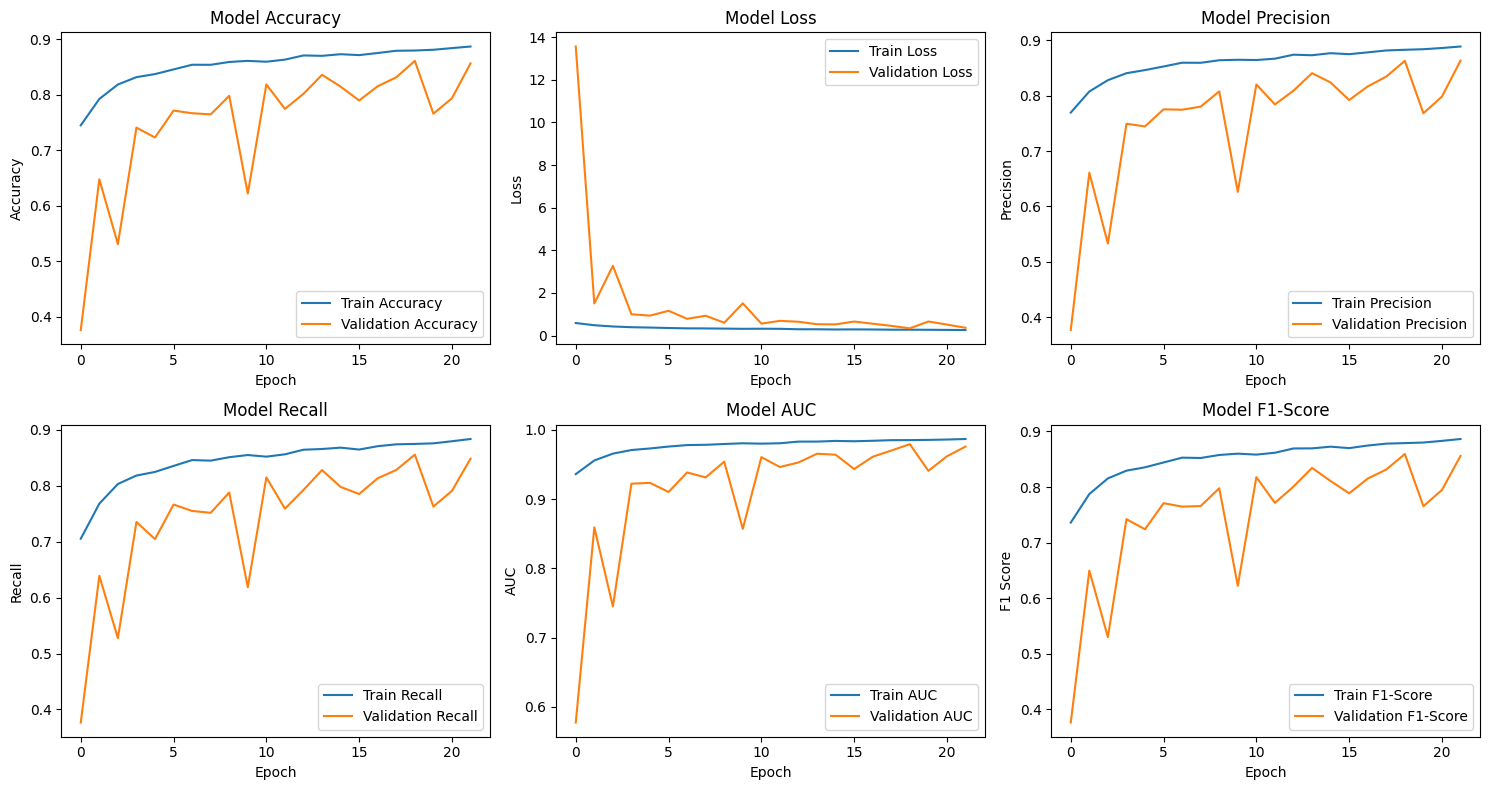

In [10]:
# Plot training & validation accuracy, loss, precision, recall, AUC, and F1-score
plt.figure(figsize=(15, 8))

# Accuracy plot
plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(2, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Precision plot
plt.subplot(2, 3, 3)
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(loc='lower right')

# Recall plot
plt.subplot(2, 3, 4)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(loc='lower right')

# AUC plot
plt.subplot(2, 3, 5)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Validation AUC')
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(loc='lower right')

# F1 Score plot
plt.subplot(2, 3, 6)
plt.plot(history.history['f1_score'], label='Train F1-Score')
plt.plot(history.history['val_f1_score'], label='Validation F1-Score')
plt.title('Model F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### Evaluate model

In [11]:
# Evaluate the model on validation data
validation_results = model.evaluate(validation_generator)

# Extract metrics
validation_loss = validation_results[0]
validation_accuracy = validation_results[1]
validation_precision = validation_results[2]
validation_recall = validation_results[3]
validation_auc = validation_results[4]
validation_f1_score = validation_results[5]

# Print validation metrics
print(f"Validation Loss: {validation_loss:.4f}")
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")
print(f"Validation Precision: {validation_precision:.4f}")
print(f"Validation Recall: {validation_recall:.4f}")
print(f"Validation AUC: {validation_auc:.4f}")
print(f"Validation F1-Score: {validation_f1_score:.4f}")

224/224 ━━━━━━━━━━━━━━━━━━━━ 20s 90ms/step - accuracy: 0.8620 - auc: 0.9798 - f1_score: 0.8610 - loss: 0.3387 - precision: 0.8643 - recall: 0.8578
Validation Loss: 0.3399
Validation Accuracy: 86.06%
Validation Precision: 0.8631
Validation Recall: 0.8558
Validation AUC: 0.9792
Validation F1-Score: 0.8594


### Performance of model

224/224 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step
Unique predicted classes: [0 1 2 3]
Unique true classes: [0 1 2 3]


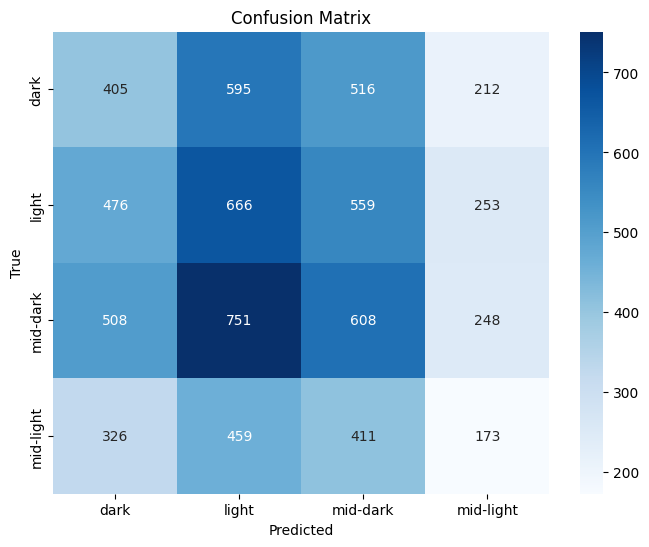

              precision    recall  f1-score   support

        dark       0.24      0.23      0.24      1728
       light       0.27      0.34      0.30      1954
    mid-dark       0.29      0.29      0.29      2115
   mid-light       0.20      0.13      0.15      1369

    accuracy                           0.26      7166
   macro avg       0.25      0.25      0.24      7166
weighted avg       0.25      0.26      0.25      7166



In [12]:
# Predict the classes on validation data
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true classes
y_true = validation_generator.classes

# Check unique predicted and true classes
unique_pred_classes = np.unique(y_pred)
unique_true_classes = np.unique(y_true)

print(f"Unique predicted classes: {unique_pred_classes}")
print(f"Unique true classes: {unique_true_classes}")

# Adjust target names to match actual predicted classes
# This ensures the classification report will reflect only the predicted classes
actual_categories = [categories[i] for i in unique_pred_classes]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=actual_categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report with adjusted labels
print(classification_report(y_true, y_pred, labels=unique_pred_classes, target_names=actual_categories))

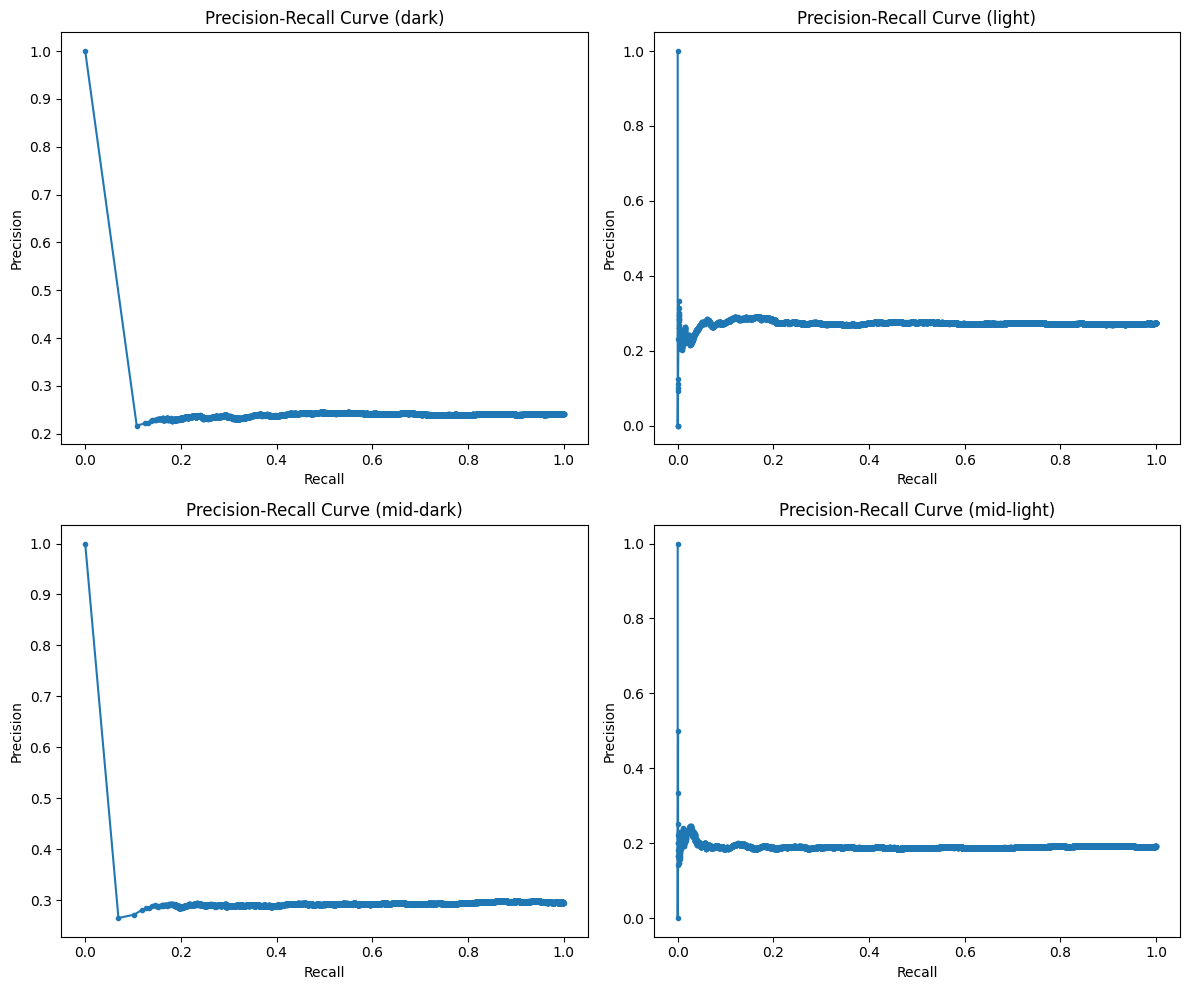

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Number of classes
num_classes = 4
class_labels = ['dark', 'light', 'mid-dark', 'mid-light']  # Adjust according to your labels

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten for easy indexing

# Loop through each class
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true == i, Y_pred[:, i])  # Compute PR curve

    axes[i].plot(recall, precision, marker='.')
    axes[i].set_title(f'Precision-Recall Curve ({class_labels[i]})')
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')

plt.tight_layout()
plt.show()

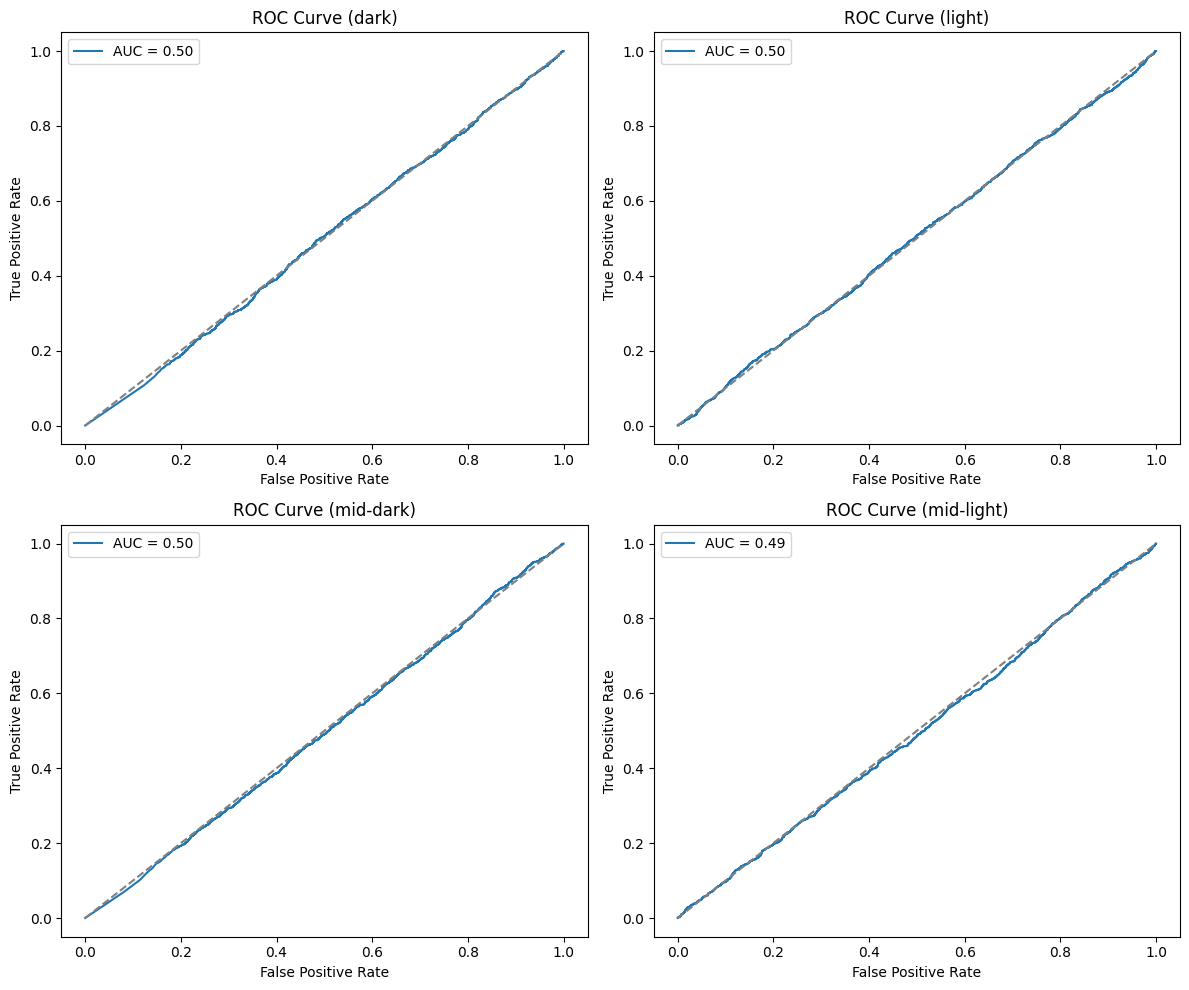

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Number of classes
num_classes = 4
class_labels = ['dark', 'light', 'mid-dark', 'mid-light']  # Adjust according to your labels

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten for easy indexing

# Loop through each class
for i in range(num_classes):
    # Convert y_true to binary for the current class
    y_true_binary = (y_true == i).astype(int)

    # Get predicted probabilities for the current class
    y_score = Y_pred[:, i]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true_binary, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    axes[i].plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    axes[i].plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
    axes[i].set_title(f'ROC Curve ({class_labels[i]})')
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].legend()

plt.tight_layout()
plt.show()

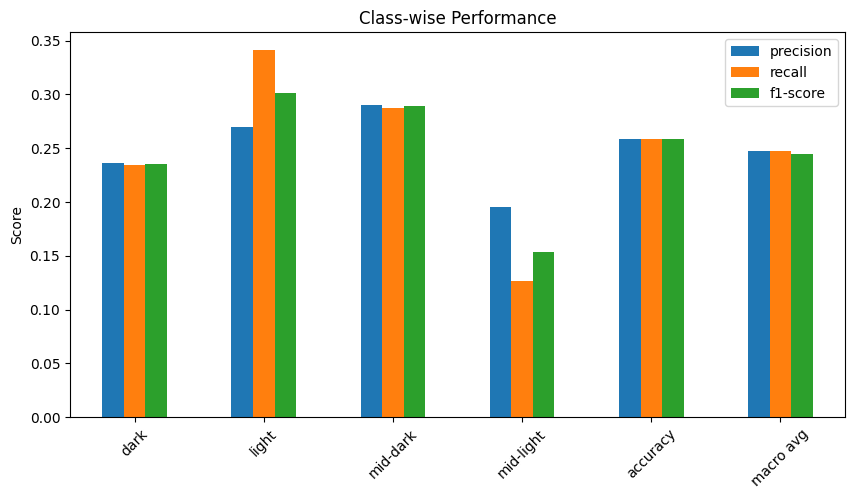

In [15]:
#Class-wise Performance (Bar Chart)

from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_true, y_pred, target_names=categories, output_dict=True)
df_report = pd.DataFrame(report).transpose()

df_report[['precision', 'recall', 'f1-score']].iloc[:-1].plot(kind='bar', figsize=(10, 5))
plt.title('Class-wise Performance')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.show()

In [16]:
# Save the trained model
model.save('content/skin_vision_model.h5')

### Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


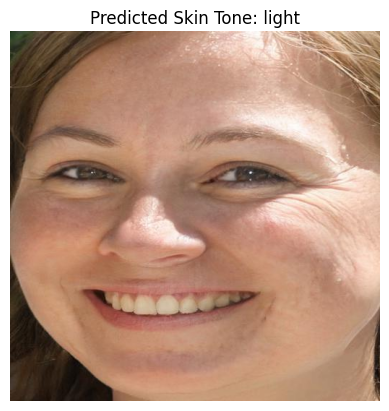

Predicted Skin Tone Class: light


In [18]:
# Load and preprocess the image
img_path = '/content/sample_data/augmented_image_7289.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# Predict skin tone
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Display the image with the predicted label
plt.imshow(image.load_img(img_path))
plt.title(f'Predicted Skin Tone: {categories[predicted_class]}')
plt.axis('off')  # Hide axis for better visualization
plt.show()

print(f'Predicted Skin Tone Class: {categories[predicted_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


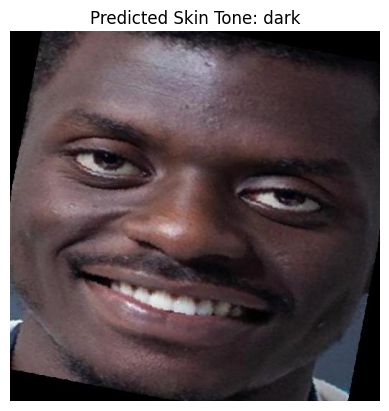

Predicted Skin Tone Class: dark


In [19]:
# Load and preprocess the image
img_path = '/content/sample_data/augmented_rotation4_augmented_rotation3_augmented_rotation2_augmented_89540330.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# Predict skin tone
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Display the image with the predicted label
plt.imshow(image.load_img(img_path))
plt.title(f'Predicted Skin Tone: {categories[predicted_class]}')
plt.axis('off')  # Hide axis for better visualization
plt.show()

print(f'Predicted Skin Tone Class: {categories[predicted_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


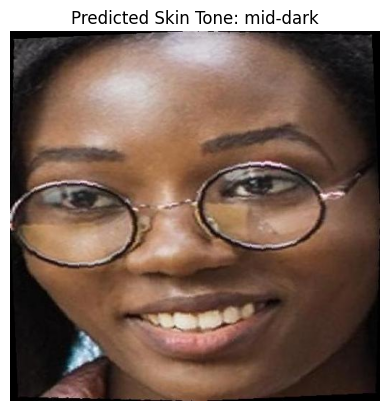

Predicted Skin Tone Class: mid-dark


In [20]:
# Load and preprocess the image
img_path = '/content/sample_data/augmented_rotation3_augmented_rotation2_augmented_rotation1_augmented_85219059.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# Predict skin tone
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Display the image with the predicted label
plt.imshow(image.load_img(img_path))
plt.title(f'Predicted Skin Tone: {categories[predicted_class]}')
plt.axis('off')  # Hide axis for better visualization
plt.show()

print(f'Predicted Skin Tone Class: {categories[predicted_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


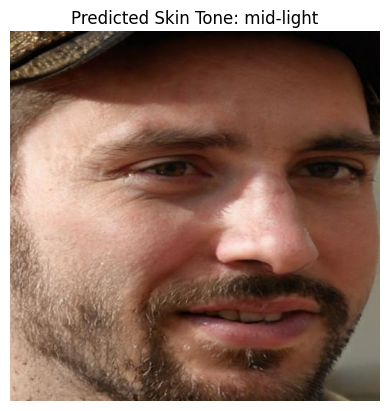

Predicted Skin Tone Class: mid-light


In [22]:
# Load and preprocess the image
img_path = '/content/sample_data/augmented_image_874.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# Predict skin tone
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Display the image with the predicted label
plt.imshow(image.load_img(img_path))
plt.title(f'Predicted Skin Tone: {categories[predicted_class]}')
plt.axis('off')  # Hide axis for better visualization
plt.show()

print(f'Predicted Skin Tone Class: {categories[predicted_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


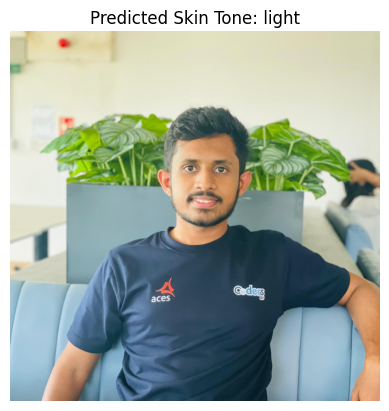

Predicted Skin Tone Class: light


In [23]:
# Load and preprocess the image
img_path = '/content/sample_data/DepProfilePic.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# Predict skin tone
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Display the image with the predicted label
plt.imshow(image.load_img(img_path))
plt.title(f'Predicted Skin Tone: {categories[predicted_class]}')
plt.axis('off')  # Hide axis for better visualization
plt.show()

print(f'Predicted Skin Tone Class: {categories[predicted_class]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


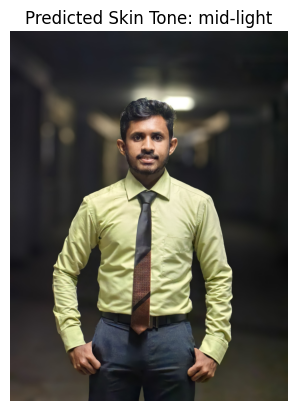

Predicted Skin Tone Class: mid-light


In [24]:
# Load and preprocess the image
img_path = '/content/sample_data/WhatsApp Image 2024-05-08 at 14.08.21_b72c541f.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# Predict skin tone
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Display the image with the predicted label
plt.imshow(image.load_img(img_path))
plt.title(f'Predicted Skin Tone: {categories[predicted_class]}')
plt.axis('off')  # Hide axis for better visualization
plt.show()

print(f'Predicted Skin Tone Class: {categories[predicted_class]}')